Import Libraries

In [191]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [192]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
import numpy as np

In [193]:
df = pd.read_csv('data/enhanced_train.csv')
df_test = pd.read_csv('data/enhanced_test.csv')

In [194]:
# Drop columns not needed for training
drop_cols = ['Unnamed: 0', 'Item_Outlet_Sales','Log_Sales']
X = df.drop(columns=drop_cols)
y = df['Log_Sales']  # Use log-transformed target


In [195]:

# 1. Create a DataFrame that includes X and stratification column
df['Log_Sales'] = y  # just in case
df['Freq_Bin_Item_Cluster'] = df['Freq_Bin_Item_Cluster'].astype(str)  # ensure string for stratification

# 2. Prepare stratified splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in splitter.split(df, df['Freq_Bin_Item_Cluster']):
    df_train_split = df.iloc[train_idx].copy()
    df_val_split = df.iloc[val_idx].copy()

# 3. Remove rows from val that contain Item_Identifiers not present in train
val_unique_items = set(df_val_split['Item_Identifier'])
train_unique_items = set(df_train_split['Item_Identifier'])

missing_items = val_unique_items - train_unique_items
print(f"Missing Item_Identifiers in train: {missing_items}")

# 4. Move those rows to train
rows_to_move = df_val_split[df_val_split['Item_Identifier'].isin(missing_items)]
df_train_split = pd.concat([df_train_split, rows_to_move], axis=0)
df_val_split = df_val_split[~df_val_split['Item_Identifier'].isin(missing_items)]


Missing Item_Identifiers in train: {'FDG40', 'FDC23', 'DRL59'}


In [196]:
X_train = df_train_split.drop(columns=['Item_Outlet_Sales', 'Log_Sales','Unnamed: 0'])
y_train = df_train_split['Log_Sales']

X_val = df_val_split.drop(columns=['Item_Outlet_Sales', 'Log_Sales','Unnamed: 0'])
y_val = df_val_split['Log_Sales']


In [197]:

# Sanity check: No missing profiles
train_profiles = set(df.loc[X_train.index, 'Item_Profile'])
val_profiles = set(df.loc[X_val.index, 'Item_Profile'])
missing_profiles = val_profiles - train_profiles
if missing_profiles:
    print(f"Warning: Some item profiles are only in validation: {missing_profiles}")

In [198]:

# One-hot encode categoricals
X_train_encoded = pd.get_dummies(X_train)
X_val_encoded = pd.get_dummies(X_val)

Type 1 - Training

In [199]:
# Align columns for both sets
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)

# # Train XGBoost model
# model = XGBRegressor(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     early_stopping_rounds=100,
# )

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,          # enough trees to capture complexity
    learning_rate=0.02,        # small step to generalize better
    max_depth=6,               # reasonable depth, avoids overfitting
    subsample=0.8,             # row sampling to reduce variance
    colsample_bytree=0.8,      # column sampling to reduce feature noise
    min_child_weight=3,        # control splits with small data
    gamma=0.1,                 # penalize unnecessary splits
    reg_alpha=1.0,             # L1 regularization (sparsity)
    reg_lambda=2.0,            # L2 regularization (stability)
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_val_encoded, y_val)],
    verbose=True
)

# 🔹 6. Evaluate model
y_val_pred_log = model.predict(X_val_encoded)
y_val_pred = np.expm1(y_val_pred_log)  # inverse of log1p
y_val_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"\n Validation RMSE (after inverse log transform): {rmse:.4f}")


[0]	validation_0-rmse:0.98603
[1]	validation_0-rmse:0.97174
[2]	validation_0-rmse:0.95784
[3]	validation_0-rmse:0.94425
[4]	validation_0-rmse:0.93095
[5]	validation_0-rmse:0.91808
[6]	validation_0-rmse:0.90571
[7]	validation_0-rmse:0.89357
[8]	validation_0-rmse:0.88171
[9]	validation_0-rmse:0.87016
[10]	validation_0-rmse:0.85892
[11]	validation_0-rmse:0.84795
[12]	validation_0-rmse:0.83715
[13]	validation_0-rmse:0.82670
[14]	validation_0-rmse:0.81655
[15]	validation_0-rmse:0.80679
[16]	validation_0-rmse:0.79718
[17]	validation_0-rmse:0.78795
[18]	validation_0-rmse:0.77893
[19]	validation_0-rmse:0.77036
[20]	validation_0-rmse:0.76218
[21]	validation_0-rmse:0.75387
[22]	validation_0-rmse:0.74591
[23]	validation_0-rmse:0.73821
[24]	validation_0-rmse:0.73088
[25]	validation_0-rmse:0.72356
[26]	validation_0-rmse:0.71640
[27]	validation_0-rmse:0.70958
[28]	validation_0-rmse:0.70282
[29]	validation_0-rmse:0.69638
[30]	validation_0-rmse:0.69037
[31]	validation_0-rmse:0.68436
[32]	validation_0-

In [200]:
X_test = pd.get_dummies(df_test.drop(columns=['Item_Identifier', 'Outlet_Identifier']))
X_test = X_test.reindex(columns=X_train_encoded.columns, fill_value=0)

test_preds_log = model.predict(X_test)
test_preds = np.expm1(test_preds_log)

# Save predictions
submission = df_test[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = test_preds
submission.to_csv('xgb_2_submission.csv', index=False)


Feature Importance - Analysis

In [201]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample some rows for speed
X_sample = X_val_encoded.sample(500, random_state=42)

# Create SHAP explainer from trained XGBoost model
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_sample)


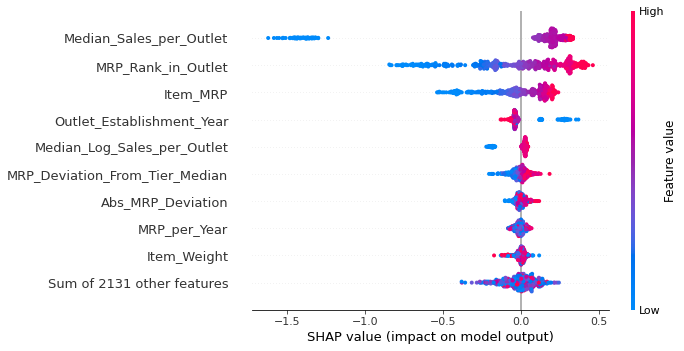

In [202]:
shap.plots.beeswarm(shap_values)


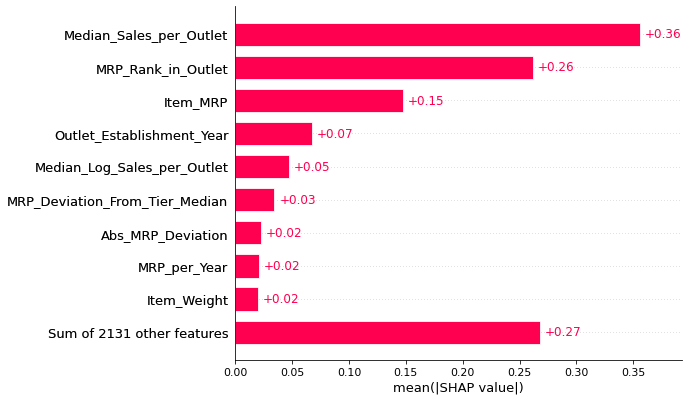

In [203]:
shap.plots.bar(shap_values)


In [204]:
# Calculate mean absolute SHAP values per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with feature names and their importance
shap_df = pd.DataFrame({
    'Feature': X_val_encoded.columns,
    'Mean_SHAP_Importance': shap_importance
})

# Sort by importance
shap_df = shap_df.sort_values(by='Mean_SHAP_Importance', ascending=False)

# Display top 20
print(shap_df.head(20))


                             Feature  Mean_SHAP_Importance
8            Median_Sales_per_Outlet              0.356361
12                MRP_Rank_in_Outlet              0.262301
2                           Item_MRP              0.147133
3          Outlet_Establishment_Year              0.067539
9        Median_Log_Sales_per_Outlet              0.047149
21    MRP_Deviation_From_Tier_Median              0.034366
22                 Abs_MRP_Deviation              0.022740
14                      MRP_per_Year              0.020614
0                        Item_Weight              0.019761
1                    Item_Visibility              0.019476
1616       Outlet_Type_Grocery Store              0.015612
6                         Outlet_Age              0.012668
20      Median_MRP_ItemType_Per_Tier              0.012135
7                  Item_Profile_Freq              0.011616
1808                Item_MRP_Bin_Low              0.008602
17       Item_Identifier_Demand_Rank              0.0078

In [205]:
list(shap_df['Feature'])

['Median_Sales_per_Outlet',
 'MRP_Rank_in_Outlet',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Median_Log_Sales_per_Outlet',
 'MRP_Deviation_From_Tier_Median',
 'Abs_MRP_Deviation',
 'MRP_per_Year',
 'Item_Weight',
 'Item_Visibility',
 'Outlet_Type_Grocery Store',
 'Outlet_Age',
 'Median_MRP_ItemType_Per_Tier',
 'Item_Profile_Freq',
 'Item_MRP_Bin_Low',
 'Item_Identifier_Demand_Rank',
 'Outlet_Cluster_Volume_Rank',
 'Item_MRP_Bin_High',
 'Outlet_Location_Type_Tier 3',
 'Item_Type_Frozen Foods',
 'Log_Visibility',
 'outlet_location_outlet_type_item_type_item_fat_content_Tier 2_Supermarket Type1_Processed Foods_Low Fat',
 'Item_Code_FDU',
 'outlet_location_outlet_type_item_type_item_fat_content_Tier 2_Supermarket Type1_Perishables_Low Fat',
 'Item_Code_FDE',
 'outlet_location_outlet_type_item_type_Tier 1_Supermarket Type1_Processed Foods',
 'outlet_location_outlet_type_item_type_item_fat_content_Tier 2_Supermarket Type1_Processed Foods_Regular',
 'outlet_location_outlet_type_item_type_i

SHAP Score of a specific Feature

In [206]:
# import shap
# import pandas as pd

# # Suppose shap_values is already calculated using shap.TreeExplainer
# shap_values = explainer.shap_values(X_train_encoded)

# # Convert to DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train_encoded.columns)

# # Get mean absolute SHAP value for a specific feature
# feature = 'Outl'
# mean_shap = shap_df[feature].abs().mean()

# print(f"Mean SHAP value for {feature}: {mean_shap:.5f}")


Checking train and test split data variety

In [207]:
train_items = set(X_train['Item_Identifier'].unique())
test_items = set(X_val['Item_Identifier'].unique())

missing_items_in_train = test_items - train_items
print("Items in test but not in train:", missing_items_in_train)


Items in test but not in train: set()


In [208]:
train_outlets = set(X_train['Outlet_Identifier'].unique())
test_outlets = set(X_val['Outlet_Identifier'].unique())

missing_outlets = test_outlets - train_outlets
print(f"Missing Outlets in Train: {missing_outlets}")


Missing Outlets in Train: set()


In [209]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
# print(categorical_columns)

for col in categorical_columns:
    train_vals = set(X_train[col].dropna().unique())
    test_vals = set(X_val[col].dropna().unique())
    diff = test_vals - train_vals
    if diff:
        print(f"New values in test for '{col}': {diff}")
